<a href="https://colab.research.google.com/github/B571/DATA72000_ERP/blob/main/Dict/Pre_processing_and_Question_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Reading a CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/CNN_Articels_clean_4800.csv'

# Using pandas' read_csv function to read the CSV file
df = pd.read_csv(file_path)

# Checking for null values
na_count = df.isna().sum().sum()
print(na_count)

# Specify the column names to be deleted
columns_to_delete = ['Index', 'Author', 'Headline', 'Description', 'Keywords', 'Second headline','Section', 'Url']

# Delete the specified columns
df1 = df.drop(columns=columns_to_delete, inplace=False)

def count_words(text):
    words = re.findall(r'\b[a-zA-Z]+\b', str(text))
    return len(words)

def remove_control_characters(text):
    # Remove control characters (ASCII 0-31 and 127)
    return re.sub(r'[\x00-\x1F\x7F]', '', text)

def remove_extra_spaces(text):
    # Replace multiple spaces with a single space and remove leading/trailing spaces
    return re.sub(r'\s+', ' ', text).strip()

# Remove control characters
df1['Article text'] = df1['Article text'].apply(remove_control_characters)

# Remove extra spaces
df1['Article text'] = df1['Article text'].apply(remove_extra_spaces)

# Count the number of words in each cell of a specific column
column_name = 'Article text'
df1[f'{column_name} word count'] = df1[column_name].apply(count_words)


0


In [ ]:
print(df1[:2])

        Date published Category  \
0  2021-07-15 02:46:59     news   
1  2021-05-12 07:52:09     news   

                                        Article text  Article text word count  
0  (CNN)Right now, there's a shortage of truck dr...                     2040  
1  (CNN)Working in a factory or warehouse can mea...                      943  


## **Do EDA about the word count of each article text**

In [ ]:
# Check basic information
print(df1['Article text word count'].describe())

In [ ]:
# Check for missing values
missing_values = df1['Article text word count'].isnull().sum()
print(f"Number of missing values: {missing_values}")

In [ ]:
# Visualize the distribution of the data (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df1['Article text word count'], bins=50, kde=True)

# Add two vertical lines
x1 = df1['Article text word count'].mean()
x2 = df1['Article text word count'].median()
print("Mean",x1, "Median",x2)
plt.axvline(x=x1, color='green', linestyle='--', linewidth=2, label=f'x={x1}')
plt.axvline(x=x2, color='red', linestyle='-.', linewidth=2, label=f'x={x2}')

# Add label
a = format(x1,'.0f')
b = format(x2,'.0f')
plt.text(x=x1, y=1000, s=f'{a}', color='green', fontsize=12, ha='left')
plt.text(x=x2, y=600, s=f'{b}', color='red', fontsize=12, ha='right')

plt.title('Histogram of word count')
plt.xlabel('Article text word count')
plt.ylabel('Frequency')
plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/word_count_histogram.png')

In [ ]:
# Visualize the distribution of the data (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df1['Article text word count'])
plt.title('Boxplot of word count')
plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/word_count_boxplot.png')

In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = df1['Article text word count'].quantile(0.25)
Q3 = df1['Article text word count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = df1[(df1['Article text word count'] < lower_bound) | (df1['Article text word count'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound -619.125 IQR 677.25 upper_bound 2089.875
Number of outliers: 273
396.75 1074.0


In [ ]:
# check for the atriles with less than x00 words

for length in range (100,400,100):
    less_art = df1[(df1['Article text word count'] <length)]
    print(f"Number of articles with less than {length}: {less_art.shape[0]}")


In [ ]:
# Delete all lines with words greater than upper_bound=2089.875 and less than 200
df1 = df1[df1[f'{column_name} word count'] <= upper_bound]
df1 = df1[df1[f'{column_name} word count'] > 200]

# Reset index column
df1 = df1.reset_index(drop=True)
print(df1.shape)

# Output new dataset
df1.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/dataset_wordCountEDA.csv', index=False)

(3690, 4)


# ***Train GPT2***

In [ ]:
import torch.nn.functional as F
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/dataset_wordCountEDA.csv')

# Split data into train and test sets
train_df, test_df = train_test_split(df1, test_size=0.8, random_state=42)

# Print the length of train and test set
print(f"Total number of training samples: {len(train_df)}")
print(f"Total number of test samples: {len(test_df)}")


In [ ]:
# Custom Dataset class for loading data
class ArticleDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            truncation=True,
            padding="max_length"
        )
        input_ids = inputs["input_ids"].squeeze()
        return {"input_ids": input_ids, "labels": input_ids}

In [ ]:
# Check whether a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Load GPT-2 model and tokenizer (use eos_tokenn as pad_token)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

In [ ]:
# Create datasets
train_dataset = ArticleDataset(train_df['Article text'].tolist(), tokenizer)
test_dataset = ArticleDataset(test_df['Article text'].tolist(), tokenizer)

In [ ]:
# Setup data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Set training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/results",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    save_steps=100,
    save_total_limit=3,
    prediction_loss_only=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Fine-tune the model
trainer.train()

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2').to('cuda')
model.eval()

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
total_loss = 0

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        # forward pass
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss
        total_loss += loss.item()

average_loss = total_loss / len(train_loader)
print(f"Average Prediction Loss: {average_loss}")

In [ ]:
# reset the index of test dataset
test_df = test_df.reset_index(drop=True)

# Output new dataset
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df.csv', index=False)

# **Qusetion 1: Relationship between real-world text and locally typical rule**

## **Calculate per-token distribution of the deviation (ε) of information content from conditional entropy using real-word text**

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

from GPT2_Calculation_SW_GPU import sliding_window_information_content_entropy, compute_local_typical_set

file_path = "/content/drive/MyDrive/Colab Notebooks/output_csv/test_df.csv"
df = pd.read_csv(file_path)

tokenizer = GPT2Tokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/results") #/content/drive/MyDrive/Colab Notebooks/results
model = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/Colab Notebooks/results").to('cuda')
tokenizer.pad_token = tokenizer.eos_token

# Define sliding window size and its stride
max_length = 1024
stride = max_length // 2

# Creat a dataframe to store category and epsilon
epsilon_df = pd.DataFrame(columns=['Category', 'epsilon'])


In [ ]:
import time

# Record start time
start_time = time.time()

for index in range(len(df)):  # len(df)
    print(index)
    column_name = 'Article text'
    text = df.loc[index, column_name]
    category = df.loc[index, 'Category']

    # Calculate information content and conditional entropy
    information_content_all, cond_entropy = sliding_window_information_content_entropy(text, model, tokenizer, max_length, stride)

    # calculate epsilon
    epsilon = - information_content_all - cond_entropy

    # Add epsilon and category to DataFrame
    new_row = pd.DataFrame({'Category': category, 'epsilon': epsilon.tolist()})
    epsilon_df = pd.concat([epsilon_df, new_row], ignore_index=True)
# Record ending time
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60} minutes")

epsilon_df.to_csv("/content/drive/MyDrive/Colab Notebooks/output_csv/real-word text epsilon_dist.csv", index=True)

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/output_csv/real-word text epsilon_dist.csv"
epsilon_df = pd.read_csv(file_path)

print(epsilon_df.shape)
print(epsilon_df['epsilon'].describe())

(2695964, 3)
count    2.695964e+06
mean     7.553391e-01
std      3.208548e+00
min     -5.117840e+00
25%     -9.999389e-01
50%     -1.693587e-02
75%      1.366198e+00
max      3.766387e+01
Name: epsilon, dtype: float64


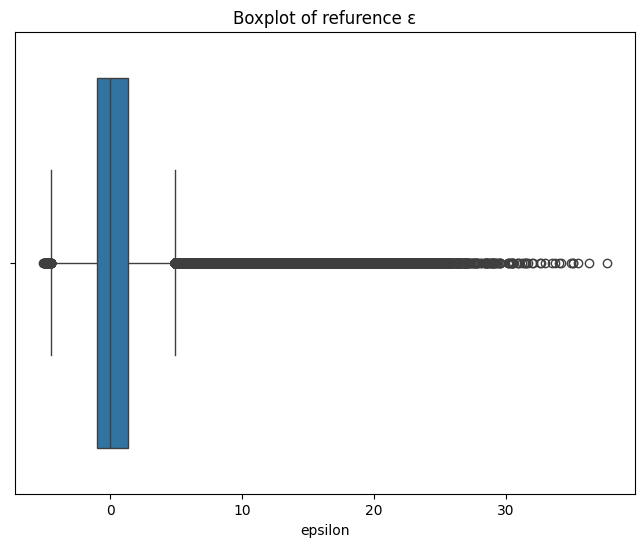

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the distribution of the data (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=epsilon_df['epsilon'])
plt.title('Boxplot of refurence ε')
plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/word_count_boxplot.png')

In [ ]:
# Check for outliers (based on the boxplot rule: 1.5 times IQR)
Q1 = epsilon_df['epsilon'].quantile(0.25)
Q3 = epsilon_df['epsilon'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower_bound",lower_bound, "IQR", IQR, "upper_bound", upper_bound)

outliers = epsilon_df[(epsilon_df['epsilon'] < lower_bound) | (epsilon_df['epsilon'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
print(Q1,Q3)

lower_bound -4.549144122749567 IQR 2.3661368265748024 upper_bound 4.915403183549643
Number of outliers: 297492
-0.9999388828873634 1.366197943687439


0.7553390760811997 -0.01693586923647665


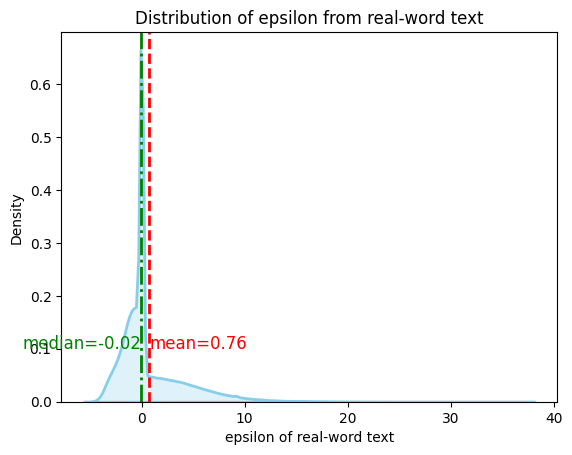

<Figure size 640x480 with 0 Axes>

In [ ]:
# Use seaborn's distplot function to plot the distribution

import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(epsilon_df['epsilon'], fill=True, color='skyblue', linewidth=2)

# Add two vertical lines with different colors and styles
x1 = epsilon_df['epsilon'].mean()
x2 = epsilon_df['epsilon'].median()
print(x1, x2)
plt.axvline(x=x1, color='red', linestyle='--', linewidth=2, label=f'x={x1}')
plt.axvline(x=x2, color='green', linestyle='-.', linewidth=2, label=f'x={x2}')

# Add labels
a = format(x1, '.2f')
b = format(x2, '.2f')
plt.text(x=x1, y=0.1, s=f'mean={a}', color='red', fontsize=12, ha='left')
plt.text(x=x2, y=0.1, s=f'median={b}', color='green', fontsize=12, ha='right')

# Set axis labels
plt.title('Distribution of epsilon from real-world text')
plt.xlabel('epsilon of real-world text')
plt.ylabel('Density')

# Display the plot
plt.show()


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/real-word text epsilon_dist.png")


In [ ]:
# Generate data
data = epsilon_df['epsilon']

from scipy.stats import gaussian_kde
# Create a KDE object
kde = gaussian_kde(data)

# Compute KDE estimates
x_vals = np.linspace(data.min(), data.max(), 1000)
kde_values = kde(x_vals)

# Create a KDE function
def kde_function(x):
    return kde(x)

from scipy.integrate import quad

# Compute the integral from -x to x
def kde_integral(x):
    integral_value, _ = quad(kde_function, -x, x)
    return integral_value

# Specify the value of x
x_value = 0.76  # You can specify any x value of interest

# Compute the area from -x to x
area = kde_integral(x_value)
print(f'The integral of the KDE function from -{x_value} to {x_value} is: {area}')


The integral of the KDE function from -0.76 to 0.76 is: 0.42899369323168846


## **Influence of Word Sequence length T on the result**

In [ ]:
# Load pre-trained models and word dividers
tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/results')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/results').to('cuda')


In [ ]:
print(next(model.parameters()).is_cuda)

True


In [ ]:
def text_generation(text, model, tokenizer, device, epsilon=0.76, known_len=50, num_iterations=100):
    # Set random seed
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Tokenize the input text and move to device
    input_ids = tokenizer(text, return_tensors='pt').input_ids.to(device)

    # Extract the real tokens starting from known_len position
    real_token_ids = input_ids[:, known_len:known_len + num_iterations].to(device)

    # Initialize a flag to check if the real token sequence is in any truncated set
    is_real_token_in_truncated_set = [False] * num_iterations

    # Initial context is the first `known_len` tokens
    current_input_ids = input_ids[:, :known_len].to(device)

    # Loop to generate tokens
    for i in range(num_iterations):
        # print(i)
        # Generate logits through the model
        with torch.no_grad():
            logits = model(current_input_ids).logits[:, -1, :]  # Get the logits of the last token

        # Convert logits to probabilities, adding a small number to avoid numerical issues
        probs = torch.softmax(logits, dim=-1) # + 1e-10

        # Compute the negative log probability
        log_probs = torch.log(probs)

        # Compute the conditional entropy H(Y_t | Y_{<t} = y_{<t})
        entropy = -(probs * log_probs).sum(dim=-1)

        # Calculate the absolute difference between log_probs and entropy
        optimization_values = torch.abs(log_probs + entropy.unsqueeze(-1))

        # Select the tokens where optimization_values is less than epsilon
        truncated_indices = torch.where(optimization_values < epsilon)[1].unsqueeze(0)

        # Check if the real token sequence is in any of the truncated sets
        if i < real_token_ids.size(1):  # Ensure we are within bounds
            real_token_id_sequence = real_token_ids[0, i:i + 1].tolist()  # Get the token ID at position i

            # Flatten truncated_indices and convert to list for comparison
            truncated_indices_list = truncated_indices[0].tolist()

            # Check if real_token_id_sequence is in the truncated_indices_list
            # print(set(real_token_id_sequence).issubset(set(truncated_indices_list)))
            is_real_token_in_truncated_set[i] = set(real_token_id_sequence).issubset(set(truncated_indices_list))

        # If the truncated set is empty, use the token with the minimum optimization value
        if truncated_indices.size(1) == 0:
            min_index = torch.argmin(optimization_values, dim=-1)
            next_token_id = min_index.squeeze()
        else:
            # Randomly select a token from the truncated set
            next_token_id = truncated_indices[:, torch.randint(truncated_indices.size(1), (1,))].squeeze()

        # Adjust the dimension of next_token_id for concatenation
        next_token_id = next_token_id.unsqueeze(0).unsqueeze(0)  # Reshape to (1, 1)

        # Update the input context and move to the correct device
        current_input_ids = torch.cat([current_input_ids, next_token_id], dim=1).to(device)

        count_true = sum(is_real_token_in_truncated_set)
        percentage = count_true/len(is_real_token_in_truncated_set)
        # print(percentage)
        # print(count_true)

    # Return a boolean indicating whether the real token sequence was in any of the truncated sets
    return percentage


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df.csv')
print(test_df.shape)

(2952, 4)


In [ ]:
# Define epsilon
epsilon = 0.76

# Change T (Size of sliding window)
section = [5,10,50,100,200]

test_df['percent_5'] = 0.01
test_df['percent_10'] = 0.01
test_df['percent_50'] = 0.01
test_df['percent_100'] = 0.01
test_df['percent_200'] = 0.01
i = 0

# Record start time
import time
start_time = time.time()

for num_iterations in section:
    print(num_iterations)
    total = 0
    for index, row in test_df.iterrows():
        # print("\t", index)
        text = row['Article text']
        a = text_generation(text, model, tokenizer, device='cuda', epsilon=0.76, known_len=50, num_iterations = num_iterations)
        test_df.at[index, f'percent_{num_iterations}'] = a


print("percent_T", percent_T)

# Record ending time
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60} minutes")



5
10
50
100
200
percent_T [0. 0. 0. 0. 0.]
Elapsed time: 159.18032276233038 minutes


In [ ]:
print(test_df.head())
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_T_result_token.csv', index=False)

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

   percent_5  percent_10  percent_50  percent_100  percent_200  
0        0.0         0.0        0.04         0.03        0.030  
1        0.0         0.0        0.02         0.05        0.045  
2        0.4         0.2        0.04         0.05        0.065  
3        0.0         0.0        0.02

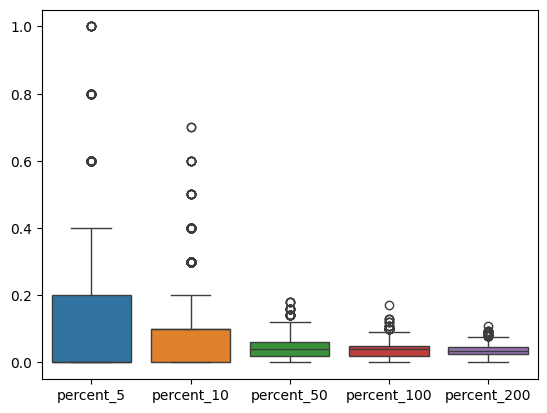

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_T_result_token.csv')

column = ['percent_5','percent_10','percent_50','percent_100','percent_200']
sns.boxplot(test_df[column])

plt.show()


[0.13089431 0.08597561 0.04420054 0.03905488 0.03733062]


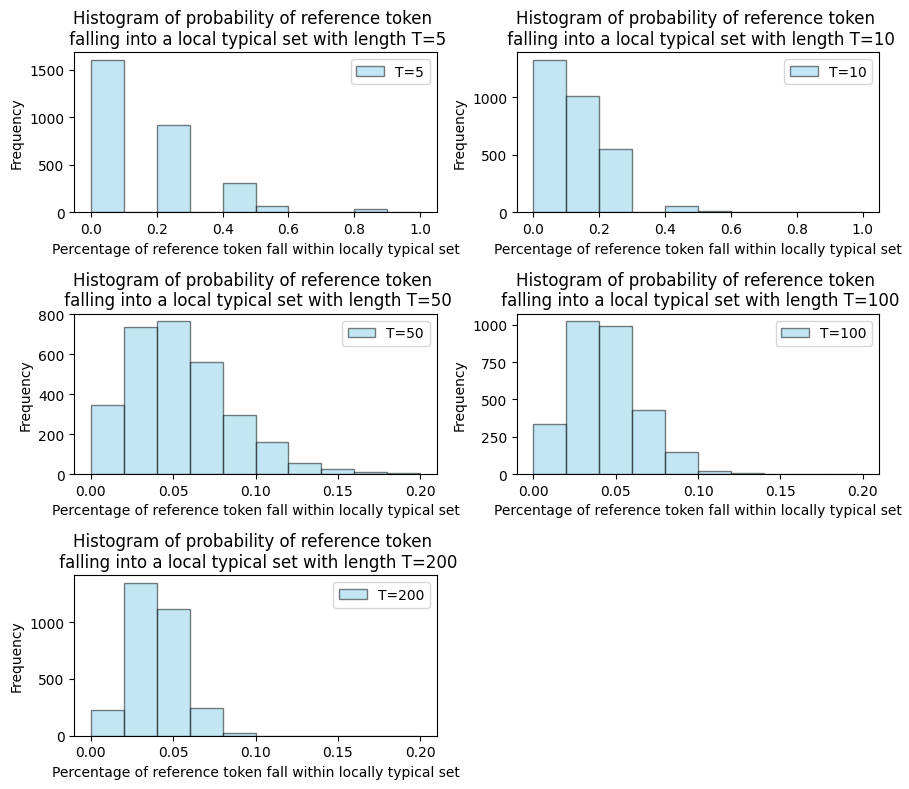

In [ ]:
section_total = [5,10,50,100,200]
percent_T = np.zeros(len(section))
i = 0

plt.figure(figsize=(9, 8))

for num_iteration in section_total:
    percent_T[i] = test_df[f'percent_{num_iteration}'].mean()
    if percent_T[i] < 0.06:
        interval = np.linspace(0, 0.2, 11)
    else:
        interval = np.linspace(0, 1, 11)
    i += 1
    plt.subplot(3, 2, i)
    plt.hist(test_df[f'percent_{num_iteration}'], bins=interval, alpha=0.5, label=f'T={num_iteration}', color='skyblue', edgecolor='black')
    plt.title(f'Histogram of probability of reference token \n falling into a local typical set with length T={num_iteration}')
    plt.xlabel('Percentage of reference token fall within locally typical set')
    plt.ylabel('Frequency')
    plt.legend()

print(percent_T)
plt.tight_layout()
plt.show()

In [ ]:
results_e0_76 = pd.DataFrame({
    'T': section_total,
    'percent': percent_T})
results_e0_76.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/percent_results_e0.76_token.csv', index=False)

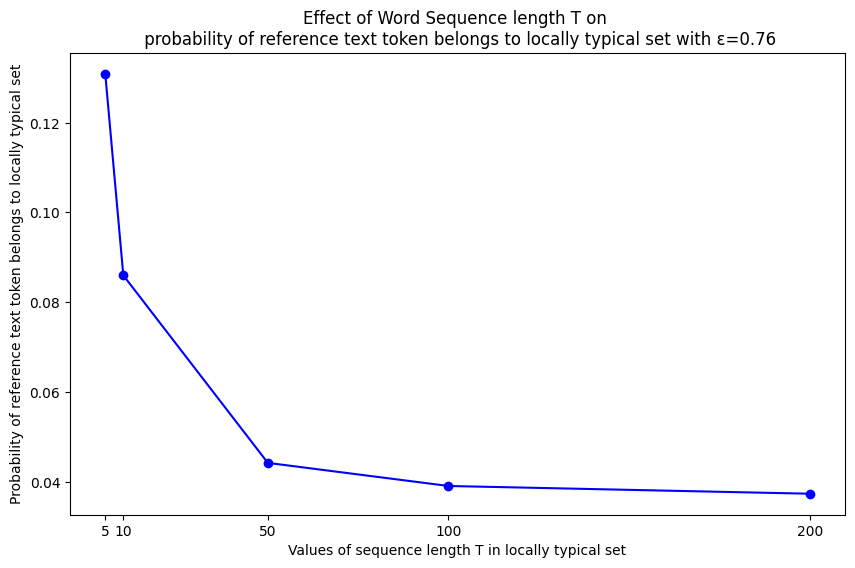

In [ ]:
results_e0_76 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/percent_results_e0.76_token.csv')

epsilon = 0.76
section_total = [5,10,50,100,200]
x_coords = section_total

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot a line chart using custom X-axis coordinates
plt.plot(x_coords, results_e0_76['percent'], marker='o', linestyle='-', color='b')

# Add title and labels
title = "Effect of Word Sequence length T on \n probability of reference text token belongs to locally typical set with ε=0.76"
plt.title(title)
plt.xlabel('Values of sequence length T in locally typical set')
plt.ylabel('Probability of reference text token belongs to locally typical set')

# Set X-axis ticks
plt.xticks(x_coords)

# Save the figure to a file
# Use the title as the filename
filename = f'{title}.png'
folder_path = '/content/drive/MyDrive/Colab Notebooks/images/'

# Ensure the filename is valid (e.g., replace illegal characters)
filename = filename.replace(':', '')

# Save the image, tightly cropped to remove excess whitespace
import os
plt.savefig(os.path.join(folder_path, filename), bbox_inches='tight')

# Display the figure
plt.show()

## **Influence of epsilon on the result**

In [ ]:
import time

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

from GPT2_Calculation_SW_GPU import sliding_window_information_content_entropy, compute_local_typical_set

In [ ]:
# Define word sequence length
num_iterations = 50

# Define epsilon
section_epsi = np.linspace(0.1, 4.9, num=49)

percent_epsi = np.zeros(section_epsi.size)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df.csv')
print(test_df.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  
0  The French territory of New Caledonia voted ag...                      393  
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649  
2  New York (CNN Business)Corporate America must ...                      949  
3  (CNN)You've just finished your tennis match an...                      724  
4  London (CNN)Relatives of Covid-19 victims have...                      524  


In [ ]:
for epsilon in section_epsi:
    test_df[f'percent_{epsilon:.2f}'] = 0.01
print(test_df.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

   percent_0.10  percent_0.20  percent_0.30  percent_0.40  percent_0.50  \
0          0.01          0.01          0.01          0.01          0.01   
1          0.01          0.01          0.01          0.01          0.01   
2          0.01          0.01          0.01          0.01          0.01

In [ ]:
import time

# Record start time
start_time = time.time()

percent_epsi = np.zeros(section_epsi.size)
i = 0

for epsilon in section_epsi:
    print(f'{epsilon:.2f}')
    total = 0
    for index, row in test_df.iterrows():
        # print("\t", index)
        text = row['Article text']
        a = text_generation(text, model, tokenizer, device='cuda', epsilon=epsilon, known_len=50, num_iterations = num_iterations)
        test_df.at[index, f'percent_{epsilon:.2f}'] = a

    percent_epsi[i] = test_df[f'percent_{epsilon:.2f}'].mean()
    i += 1

# Record ending time
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60} minutes")

0.10
0.20
0.30
0.40
0.50
0.60
0.70
0.80
0.90
1.00
1.10
1.20
1.30
1.40
1.50
1.60
1.70
1.80
1.90
2.00
2.10
2.20
2.30
2.40
2.50
2.60
2.70
2.80
2.90
3.00
3.10
3.20
3.30
3.40
3.50
3.60
3.70
3.80
3.90
4.00
4.10
4.20
4.30
4.40
4.50
4.60
4.70
4.80
4.90
Elapsed time: 1034.9100405057272 minutes


In [ ]:
print(percent_epsi)
print(test_df.head())

[0.00718157 0.01258808 0.01850949 0.02422087 0.02957317 0.03556911
 0.04137534 0.04705285 0.05187669 0.05724932 0.06491192 0.06989837
 0.07642276 0.08344173 0.08944444 0.09415989 0.10369241 0.10834688
 0.11491192 0.12256098 0.12971545 0.135      0.14313008 0.14947832
 0.15503388 0.16426152 0.17130081 0.17947154 0.18680894 0.19522358
 0.2024729  0.21096883 0.22017615 0.23170732 0.23979675 0.24958672
 0.26058943 0.27079268 0.28085366 0.2899187  0.2996206  0.31281843
 0.3225813  0.33663279 0.35017615 0.35434959 0.37058943 0.38448509
 0.40017615]
        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                    

In [ ]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_epsi_result_token.csv', index=False)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_epsi_result_token.csv')

In [ ]:
results_epsi = pd.DataFrame({
    'epsilon': section_epsi,
    'percent': percent_epsi})
results_epsi.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/percent_results_epsi_token.csv', index=False)

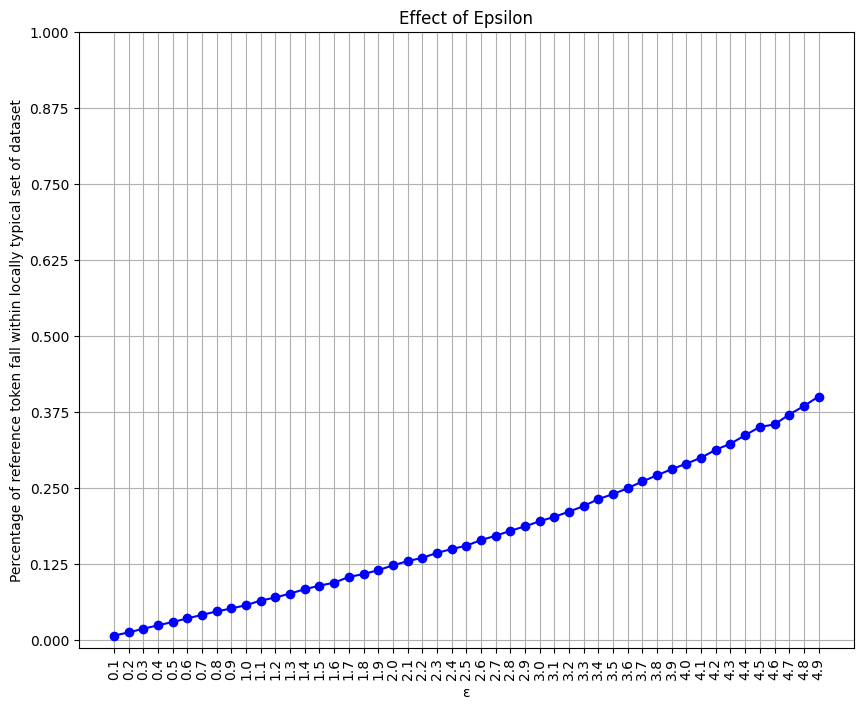

In [ ]:
results_epsi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/percent_results_epsi_token.csv')

section_epsi = np.linspace(0.1, 4.9, num=49)
num_iterations = 1

x_coords = section_epsi

# Create a new figure
plt.figure(figsize=(10, 8))

# Plot a line chart using custom X-axis coordinates
plt.plot(x_coords, results_epsi['percent'], marker='o', linestyle='-', color='b')

# Add title and labels
title = 'Effect of Epsilon on the probability of reference token fall within locally typical set of dataset'
plt.title(title)
plt.xlabel('ε')
plt.ylabel('Probability of reference token fall within locally typical set of dataset')

# Set X-axis ticks
plt.xticks(np.linspace(0.1, 4.9, num=49),rotation = 90)

# Set Y-axis ticks
plt.yticks(np.linspace(0, 1, num=9))


# Display grid
plt.grid(True)

# Save the figure to a file
# Use the title as the filename
filename = f'{title}.png'
folder_path = '/content/drive/MyDrive/Colab Notebooks/images/'

# Ensure the filename is valid (e.g., replace illegal characters)
filename = filename.replace(':', '')

# Save the image, tightly cropped to remove excess whitespace
import os
plt.savefig(os.path.join(folder_path, filename), bbox_inches='tight')

# Display the figure
plt.show()

Fitted Quadratic Equation: 
         2
0.00797 x + 0.03894 x + 0.009357

Derivative of the Quadratic Equation: 
 
0.01594 x + 0.03894


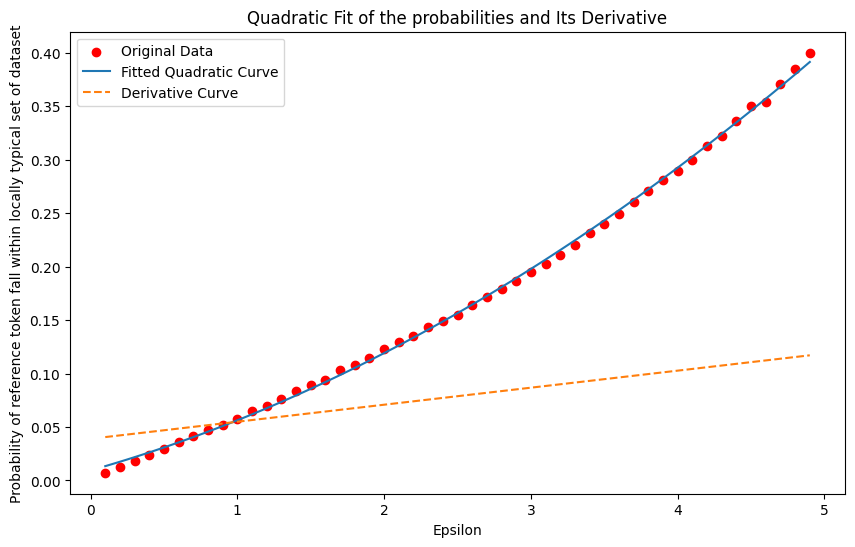

In [ ]:
# Polynomial fitting of a quadratic equation
coefficients = np.polyfit(section_epsi, results_epsi['percent'], 2)
quadratic_poly = np.poly1d(coefficients)

# Print the fitted polynomial equation
print("Fitted Quadratic Equation: ")
print(quadratic_poly)

# Calculate the derivative
derivative_poly = quadratic_poly.deriv()

# Print the derivative
print("\nDerivative of the Quadratic Equation: ")
print(derivative_poly)

# Visualize the fitted curve and its derivative
x_vals = np.linspace(min(section_epsi), max(section_epsi), 100)
y_vals = quadratic_poly(x_vals)
y_derivative_vals = derivative_poly(x_vals)

plt.figure(figsize=(10, 6))

# Original data points
plt.scatter(section_epsi, results_epsi['percent'], color='red', label='Original Data')

# Fitted quadratic curve
plt.plot(x_vals, y_vals, label='Fitted Quadratic Curve')

# Derivative curve
plt.plot(x_vals, y_derivative_vals, label='Derivative Curve', linestyle='--')

# Add legend and labels
plt.xlabel('Epsilon')
plt.ylabel('Probability of reference token fall within locally typical set of dataset')
plt.title('Quadratic Fit of the probabilities and Its Derivative')
plt.legend()

plt.show()

## **The probability of matching text using MIROSTAT**

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df.csv')

test_df['MIROSTST_text'] = "Geerated text by MIROSTAT"
print(test_df.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

               MIROSTST_text  
0  Geerated text by MIROSTAT  
1  Geerated text by MIROSTAT  
2  Geerated text by MIROSTAT  
3  Geerated text by MIROSTAT  
4  Geerated text by MIROSTAT  


@inproceedings{
BasuRKV2021,
title={MIROSTAT: A NEURAL TEXT DECODING ALGORITHM THAT DIRECTLY CONTROLS PERPLEXITY},
author={Sourya Basu and Govardana Sachitanandam Ramachandran and Nitish Shirish Keskar and Lav R. Varshney},
booktitle={International Conference on Learning Representations},
year={2021},
url={https://openreview.net/forum?id=W1G1JZEIy5_}
}

In [ ]:
#Example Use:
#python mirostat.py --num_tokens 200 --tau 3.0 --context "/context.txt"
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math


def estimate_s(prob):
  result = 0
  num = 0
  den = 0
  for i in range(100):
    b = prob[i]/prob[i+1]
    t = (i+2)/(i+1)
    num += math.log(b)*math.log(t)
    den += math.log(t)**2
  return num/den


def compute_k(n,s,tau):
    eps = s-1
    k = ((eps*(2**(tau)))/(1-n**(-eps)))**(1/s)
    k = round(k)
    return k


print("Mirostat sampling!")

tokenizer = GPT2Tokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/results")
model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/results')

target_surprise = 3
max_surprise = 2*target_surprise
error_surprise = 0
running_tot_surprise = 0
learning_rate = 1
num_tokens = 100
n=50000 #Vocabulary size

for index, row in test_df.iterrows():
    text = row['Article text']
    context_text = text
    context = torch.tensor([tokenizer.encode(context_text)])[:, :50]
    generated = []
    prev = context
    past = None


    model.eval()

    # If you have a GPU, put everything on cuda
    context = context.to('cuda')
    model.to('cuda')

    with torch.no_grad():

        for i in range(num_tokens):
            forward = model(input_ids=context, past_key_values=past, return_dict=True)
            logits = forward.logits[0, -1, :]
            past = forward.past_key_values

            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            prob_original = torch.softmax(sorted_logits, dim=-1).tolist()

            # Estimate s
            s = estimate_s(prob_original)
            # Compute k
            k = compute_k(n,s,max_surprise)+1

            sorted_logits = sorted_logits[0:k]
            sorted_indices = sorted_indices[0:k]

            prob_topk = torch.softmax(sorted_logits, dim = 0)
            prev_i = torch.multinomial(prob_topk, num_samples=1, replacement=True)
            index_surprise = math.log2(1/prob_original[prev_i])

            running_tot_surprise += index_surprise
            prev = sorted_indices[prev_i]
            generated += prev.tolist()
            context = torch.tensor([prev.tolist()]).to('cuda')  # add ".to('cuda')" if you have a GPU

            # adjust max_surprise
            error_surprise = index_surprise - target_surprise
            max_surprise -= learning_rate*error_surprise

    test_df.at[index, 'MIROSTST_text'] = tokenizer.decode(generated)
    print(index)
    print("\t Context text:",context_text)
    print("\t Generated text:",tokenizer.decode(generated))


Mirostat sampling!
0
	 Context text: The French territory of New Caledonia voted against independence in a referendum on Sunday, provisional results showed, amid a big drop in turnout due to a boycott of the vote by the independence movement.The indigenous Kanak population, who largely favor independence, had called for non-participation in the referendum because they are in a 12-month mourning period following a September surge in coronavirus infections.Provisional results published by French authorities showed support for a "no" to independence was at 96.5%, while turnout stood at 43.9%. Sunday's vote, the third and final ballot on the issue, follows two previous polls in 2018 and 2020 in which the "no" vote got 57% and 53% respectively."The Caledonians have chosen to remain French. They decided that freely," French President Emmanuel Macron said in a televised address.French president Emmanuel Macron gives a national TV address on December 12 after the third independence referendum 

Token indices sequence length is longer than the specified maximum sequence length for this model (1134 > 1024). Running this sequence through the model will result in indexing errors


流式输出内容被截断，只能显示最后 5000 行内容。
	 Context text: (CNN)Golfer Michael Visacki could not contain his emotion on Monday after the dream of qualifying for his first PGA Tour event finally came true. The American fell into the arms of his caddie and burst into tears after sinking his final qualifying putt at the Valspar Championship before calling his dad to tell him the good news. The heart-warming moment of Visacki crying on the phone to his father has since gone viral and has underlined just how hard the 27-year-old has had to work. Bunny attends baseball game and everyone is in love with it"I made it," Visacki told his father, before both began crying. It's quite literally been a long road for Visacki to get to this point. He's traveled over a hundred thousand miles in his Honda Accord in pursuit of his sporting ambitions. Read MoreAs a promising junior, he turned pro in 2014 but has since been struck by misfortune. He came close to making his first cut in 2019 but missed out by one shot afte

In [ ]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_mirostat.csv', index=False)

In [ ]:
test_df_mirostat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_mirostat.csv')
print(test_df_mirostat.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

                                       MIROSTST_text  \
0   has been in the minority in some parts of the...   
1   firm, Team Mercedes, said last week that it w...   
2  , attorneys general in 5 state and Washington ...   
3   millions.\n\nI was in the room with my wife a...   
4   to be a repr

In [ ]:
# Define a function to tokenize the text, select the first 150 tokens, and then convert it back to text
def process_text(text):
    tokenizer = GPT2Tokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/results")

    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Select the first 50 to 150 tokens
    selected_tokens = tokens[0:50]

    # Convert these tokens back to text
    processed_text = tokenizer.convert_tokens_to_string(selected_tokens)

    return processed_text


In [ ]:
test_df_mirostat['given_reference'] = test_df_mirostat['Article text'].apply(process_text)
print(test_df_mirostat.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

                                       MIROSTST_text  \
0   has been in the minority in some parts of the...   
1   firm, Team Mercedes, said last week that it w...   
2  , attorneys general in 5 state and Washington ...   
3   millions.\n\nI was in the room with my wife a...   
4   to be a repr

In [ ]:
test_df_mirostat.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_mirostat.csv', index=False)

In [ ]:
test_df_mirostat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_mirostat.csv')
print(test_df_mirostat.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

                                       MIROSTST_text  \
0   has been in the minority in some parts of the...   
1   firm, Team Mercedes, said last week that it w...   
2  , attorneys general in 5 state and Washington ...   
3   millions.\n\nI was in the room with my wife a...   
4   to be a repr

In [ ]:
# Define epsilon
epsilon = 0.76

# Change T (Size of sliding window)
section = [5,10,50,100,200]
test_df_mirostat['percen_5'] = 0.0001
test_df_mirostat['percen_10'] = 0.0001
test_df_mirostat['percen_50'] = 0.0001
test_df_mirostat['percen_100'] = 0.0001
test_df_mirostat['percen_200'] = 0.0001

i = 0

# Record start time
import time
start_time = time.time()

for num_iterations in section:
    print(num_iterations)
    total = 0
    for index, row in test_df_mirostat.iterrows():
        # print("\t", index)
        text = row['given_reference'] + " " + row['MIROSTST_text']
        a = text_generation(text, model, tokenizer, device='cuda', epsilon=0.76, known_len=50, num_iterations = num_iterations)
        test_df_mirostat.at[index, f'percen_{num_iterations}'] = a


# Record ending time
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60} minutes")

test_df_mirostat.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_mirostat_token.csv', index=False)

5
10
50
100
200
Elapsed time: 160.22394445737203 minutes


In [ ]:
test_df_mirostat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_mirostat_token.csv')
print(test_df_mirostat.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

                                       MIROSTST_text  \
0   has been in the minority in some parts of the...   
1   firm, Team Mercedes, said last week that it w...   
2  , attorneys general in 5 state and Washington ...   
3   millions.\n\nI was in the room with my wife a...   
4   to be a repr

In [ ]:
# Modify column name
test_df_mirostat = test_df_mirostat.rename(columns=lambda x: x.replace('percen_', 'percent_'))
print(test_df_mirostat.columns)

Index(['Date published', 'Category', 'Article text', 'Article text word count',
       'MIROSTST_text', 'given_reference', 'percent_5', 'percent_10',
       'percent_50', 'percent_100', 'percent_200'],
      dtype='object')


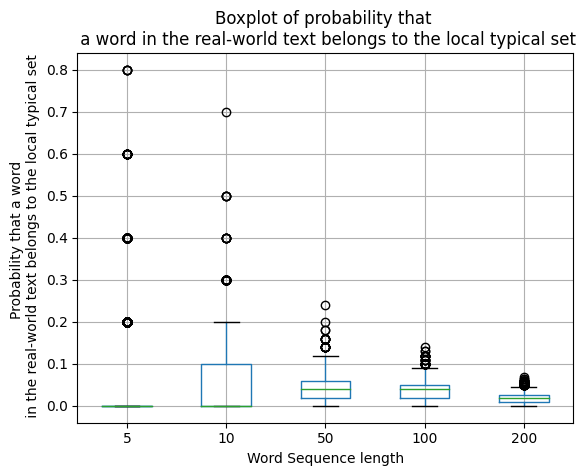

In [ ]:
column = ['percent_5','percent_10','percent_50','percent_100','percent_200']
test_df_mirostat.boxplot(column=column)

plt.xlabel('Word Sequence length')
plt.ylabel('Probability that a word \n in the real-world text belongs to the local typical set')
plt.xticks(range(1, len(column) + 1), ['5', '10', '50', '100', '200'])
plt.title('Boxplot of probability that \n a word in the real-world text belongs to the local typical set')
plt.show()

[0.05487805 0.04871274 0.0395393  0.03887873 0.01961043]


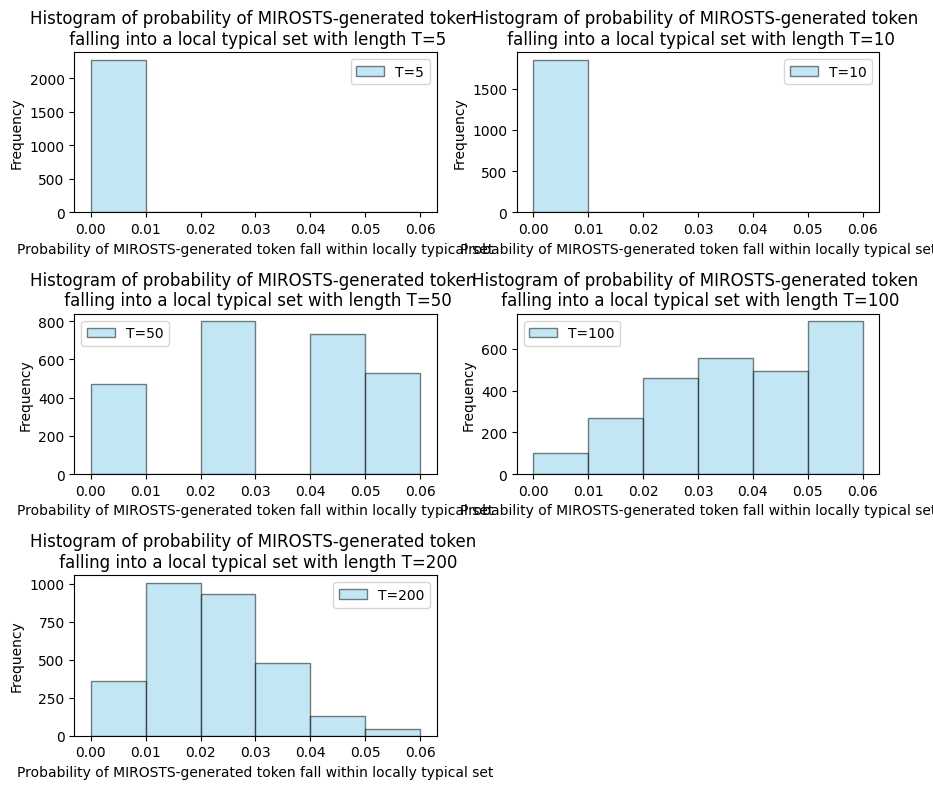

In [ ]:
section_total = [5,10,50,100,200]
percent_T_MIR0STAT = np.zeros(len(section))

i = 0

plt.figure(figsize=(9, 8))

for num_iteration in section_total:
    percent_T_MIR0STAT[i] = test_df_mirostat[f'percent_{num_iteration}'].mean()
    i += 1
    # print histogram
    plt.subplot(3, 2, i)
    plt.hist(test_df_mirostat[f'percent_{num_iteration}'], bins=np.linspace(0, 0.06, 7), alpha=0.5, label=f'T={num_iteration}', color='skyblue', edgecolor='black')
    plt.title(f'Histogram of probability of MIROSTS-generated token \n falling into a local typical set with length T={num_iteration}')
    plt.xlabel('Probability of MIROSTS-generated token fall within locally typical set')
    plt.ylabel('Frequency')
    plt.legend()

print(percent_T_MIR0STAT)
plt.tight_layout()
plt.show()

In [ ]:
results_e0_76 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/percent_results_e0.76_token.csv')
results_e0_76['percent_MIROSTAT'] = percent_T_MIR0STAT
results_e0_76.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/percent_results_e0.76_token.csv', index=False)

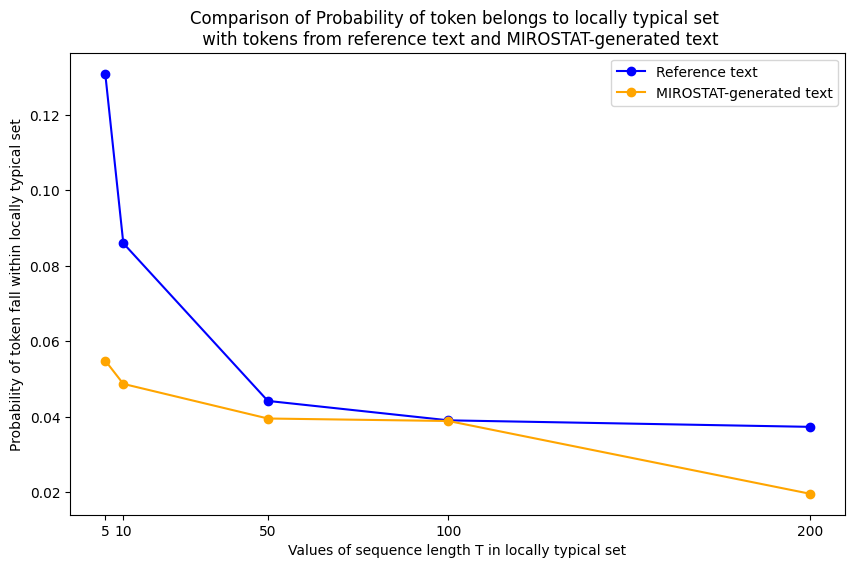

In [ ]:
results_e0_76 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/percent_results_e0.76_token.csv')

x_coords = [5,10,50,100,200]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot a line chart using custom X-axis coordinates
plt.plot(x_coords, results_e0_76['percent'], label='Reference text', marker='o', linestyle='-', color='b')
plt.plot(x_coords, results_e0_76['percent_MIROSTAT'], label='MIROSTAT-generated text', color='orange', marker='o')

# Add title and labels
title = "Comparison of Probability of token belongs to locally typical set \n with tokens from reference text and MIROSTAT-generated text"
plt.title(title)
plt.xlabel('Values of sequence length T in locally typical set')
plt.ylabel('Probability of token fall within locally typical set')

# Set X-axis ticks
plt.xticks(x_coords)

# Save the figure to a file
# Use the title as the filename
filename = f'{title}.png'
folder_path = '/content/drive/MyDrive/Colab Notebooks/images/'

# Ensure the filename is valid (e.g., replace illegal characters)
filename = filename.replace(':', '')

# Save the image, tightly cropped to remove excess whitespace
import os
plt.savefig(os.path.join(folder_path, filename), bbox_inches='tight')

# Display the figure
plt.legend()
plt.show()


## **The influence of known length on the result**

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df.csv')
print(test_df.head())

In [ ]:
# Define epsilon
epsilon = 0.76

# Change T (Size of sliding window)
section = [50,100,200]
test_df_k['known_length_50'] = 0.0000001
test_df_k['known_length_100'] = 0.0000001
test_df_k['known_length_200'] = 0.0000001

i = 0

# Record start time
import time
start_time = time.time()

for known_length in section:
    total = 0
    for index, row in test_df_k.iterrows():
        # print("\t", index)
        text = row['Article text']
        a = text_generation(text, model, tokenizer, device='cuda', epsilon=0.76, known_len=known_length, num_iterations = 50)
        test_df_k.at[index, f'known_length_{known_length}'] = a



# Record ending time
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60} minutes")



Elapsed time: 67.88000540335973 minutes


In [ ]:
print(test_df_k.head())

        Date published  Category  \
0  2021-12-13 02:05:22      news   
1  2021-12-08 15:24:55     sport   
2  2021-06-14 17:03:00  business   
3  2021-02-10 12:48:36     sport   
4  2021-10-13 16:16:46      news   

                                        Article text  Article text word count  \
0  The French territory of New Caledonia voted ag...                      393   
1  (CNN)Mercedes' F1 team announced on Wednesday ...                      649   
2  New York (CNN Business)Corporate America must ...                      949   
3  (CNN)You've just finished your tennis match an...                      724   
4  London (CNN)Relatives of Covid-19 victims have...                      524   

   known_length_50  known_length_100  known_length_200  
0             0.04              0.04              0.06  
1             0.02              0.06              0.02  
2             0.04              0.00              0.06  
3             0.02              0.04              0.14  
4          

In [ ]:
test_df_k.to_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_k_token.csv', index=False)

In [ ]:
test_df_k = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_csv/test_df_k_token.csv')

In [ ]:
percent_k = np.zeros(len(section))
for e_idx, known_length in enumerate(section):
    percent_k[e_idx] = test_df_k[f'known_length_{known_length}'].mean()
print(percent_k)

[0.04420054 0.04472222 0.04431572]


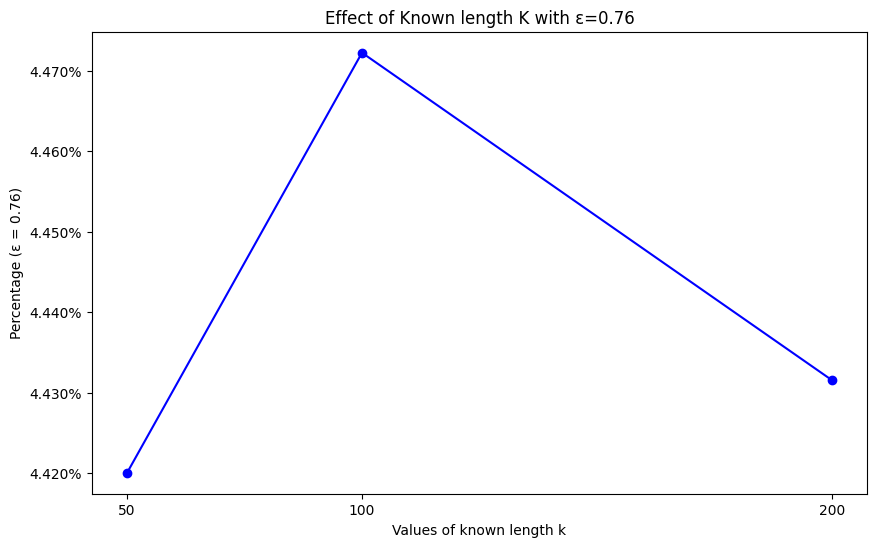

In [ ]:
import matplotlib.ticker as mtick

epsilon = 0.76
section_total = [50,100,200]
x_coords = section_total

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the line graph using custom X-axis coordinates
plt.plot(x_coords, [p * 100 for p in percent_k], marker='o', linestyle='-', color='b')

# Add title and labels
title = "Effect of Known length K with ε=0.76"
plt.title(title)
plt.xlabel('Values of known length k')
plt.ylabel('Percentage (ε = 0.76)')

# Set Y-axis ticks to display percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Set X-axis ticks
plt.xticks(x_coords)

# Ensure the directory for saving the image exists
folder_path = '/content/drive/MyDrive/Colab Notebooks/images/'
os.makedirs(folder_path, exist_ok=True)

# Save the image to a file
filename = f'{title}.png'.replace(':', '')  # Replace illegal characters
plt.savefig(os.path.join(folder_path, filename), bbox_inches='tight')

# Display the image
plt.show()
